# EFL Championship

## Predicting the Winning Football Team

Can we design a predictive model capable of accurately predicting if the home team will win a football match? 


## Steps

1. We will clean our dataset
2. Split it into training and testing data (12 features & 1 target (winning team (Home/Away/Draw))
3. Train 3 different classifiers on the data 
  -Logistic Regression
  -Support Vector Machine 
  -XGBoost
4. Use the best Classifer to predict who will win given an away team and a home team

## History

Sports betting is a 500 billion dollar market (Sydney Herald)

![alt text](https://static1.squarespace.com/static/506a95bbc4aa0491a951c141/t/51a55d97e4b00f4428967e64/1369791896526/sports-620x349.jpg "Logo Title Text 1")

Kaggle hosts a yearly competiton called March Madness 

https://www.kaggle.com/c/march-machine-learning-mania-2017/kernels

Several Papers on this 

https://arxiv.org/pdf/1511.05837.pdf

"It is possible to predict the winner of English county twenty twenty cricket games in almost two thirds of instances."

https://arxiv.org/pdf/1411.1243.pdf

"Something that becomes clear from the results is that Twitter contains enough information to be useful for
predicting outcomes in the Premier League"

https://qz.com/233830/world-cup-germany-argentina-predictions-microsoft/

For the 2014 World Cup, Bing correctly predicted the outcomes for all of the 15 games in the knockout round.

So the right questions to ask are

-What model should we use?
-What are the features (the aspects of a game) that matter the most to predicting a team win? Does being the home team give a team the advantage? 

## Dataset

- Football is played by 250 million players in over 200 countries (most popular sport globally)
- The English Premier League is the most popular domestic team in the world
- Retrived dataset from http://football-data.co.uk/data.php

![alt text](http://i.imgur.com/YRIctyo.png "Logo Title Text 1")

- Football is a team sport, a cheering crowd helps morale
- Familarity with pitch and weather conditions helps
- No need to travel (less fatigue)

Acrononyms- https://rstudio-pubs-static.s3.amazonaws.com/179121_70eb412bbe6c4a55837f2439e5ae6d4e.html

## Other repositories

- https://github.com/rsibi/epl-prediction-2017 (EPL prediction)
- https://github.com/adeshpande3/March-Madness-2017 (NCAA prediction)

## Import Dependencies

In [1]:
#data preprocessing
import pandas as pd
#produces a prediction model in the form of an ensemble of weak prediction models, typically decision tree
import xgboost as xgb
#the outcome (dependent variable) has only a limited number of possible values. 
#Logistic Regression is used when response variable is categorical in nature.
from sklearn.linear_model import LogisticRegression
#A random forest is a meta estimator that fits a number of decision tree classifiers 
#on various sub-samples of the dataset and use averaging to improve the predictive 
#accuracy and control over-fitting.
from sklearn.ensemble import RandomForestClassifier
#a discriminative classifier formally defined by a separating hyperplane.
from sklearn.svm import SVC
#displayd data
from IPython.display import display
%matplotlib inline

C:\Users\JNC\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Read data and drop redundant column.
loc = "./Datasets_Championship/"
data = pd.read_csv(loc + 'final_dataset.csv')

# Remove first 3 matchweeks
data = data[data.MW > 3]

data_original = data.copy()

#data.drop(['Unnamed: 0','HomeTeam', 'AwayTeam', 'Date', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'FTHG', 'FTAG',
#           'HTGS', 'ATGS', 'HTGC', 'ATGC','HomeTeamLP', 'AwayTeamLP','DiffPts','HTFormPts','ATFormPts',
#           'HM4','HM5','AM4','AM5','HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',
#           'HTWinStreak3','HTLossStreak3','ATWinStreak3','ATLossStreak3'],1, inplace=True)

data.drop(['Unnamed: 0','HomeTeam', 'AwayTeam', 'Date', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'FTHG', 'FTAG',
           'HTGS', 'ATGS', 'HTGC', 'ATGC',
           'HomeTeamLP', 'AwayTeamLP','DiffPts',
           'HTFormPts','ATFormPts',
           'HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',
           'HTWinStreak3','HTLossStreak3','ATWinStreak3','ATLossStreak3'],1, inplace=True)



# Preview data.
display(data.head())


#Full Time Result (H=Home Win, D=Draw, A=Away Win)
#HTGD - Home team goal difference
#ATGD - away team goal difference
#HTP - Home team points
#ATP - Away team points
#DiffFormPts Diff in points
#DiffLP - Differnece in last years prediction

#Input - 12 other features (fouls, shots, goals, misses,corners, red card, yellow cards)
#Output - Full Time Result (H=Home Win, D=Draw, A=Away Win) 

,FTR,HTP,ATP,HM1,HM2,HM3,HM4,HM5,AM1,AM2,...,HM2_H_PTS,HM2_A_PTS,AM1_H_PTS,AM1_A_PTS,AM2_H_PTS,AM2_A_PTS,HTGD,ATGD,DiffFormPts,DiffLP
36,0,0.50,1.75,L,D,D,M,M,W,W,...,0.0,1.0,6.0,4.0,1.0,3.0,-1.00,0.50,-1.25,8.0
37,1,1.25,1.00,D,D,W,M,M,D,W,...,1.0,3.0,3.0,3.0,0.0,1.0,0.25,-0.25,0.25,6.0
38,0,0.25,1.00,D,L,L,M,M,L,D,...,1.0,0.0,2.0,4.0,3.0,0.0,-0.50,-0.25,-0.75,5.0
39,0,1.25,0.75,W,D,D,M,M,L,W,...,3.0,1.0,1.0,3.0,0.0,3.0,0.50,-0.50,0.50,-12.0
40,0,0.50,0.50,L,D,D,M,M,D,L,...,1.0,1.0,4.0,1.0,1.0,0.0,-0.25,-0.50,0.00,2.0


## Data Exploration

In [3]:
#what is the win rate for the home team?

# Total number of matches.
n_matches = data.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = data.shape[1] - 1

# Calculate matches won by home team.
#n_homewins = len(data[data.FTR == 'H'])
n_homewins = len(data[data.FTR == 0])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print( "Total number of matches: {}".format(n_matches) )
print( "Number of features: {}".format(n_features) )
print( "Number of matches won by home team: {}".format(n_homewins) )
print( "Win rate of home team: {:.2f}%".format(win_rate) )

Total number of matches: 6286
Number of features: 44
Number of matches won by home team: 2747
Win rate of home team: 43.70%


C:\Users\JNC\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A9E3351438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001A9E44CB2E8>]], dtype=object)

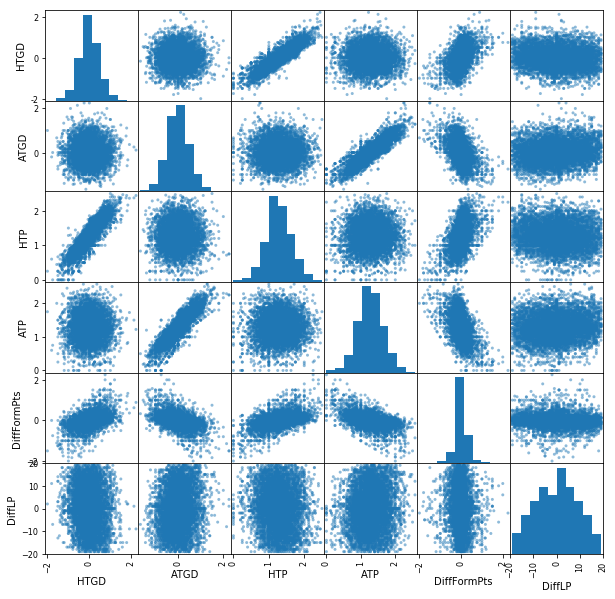

In [4]:
# Visualising distribution of data
from pandas.tools.plotting import scatter_matrix

#the scatter matrix is plotting each of the columns specified against each other column.
#You would have observed that the diagonal graph is defined as a histogram, which means that in the 
#section of the plot matrix where the variable is against itself, a histogram is plotted.

#Scatter plots show how much one variable is affected by another. 
#The relationship between two variables is called their correlation
#negative vs positive correlation

#HTGD - Home team goal difference
#ATGD - away team goal difference
#HTP - Home team points
#ATP - Away team points
#DiffFormPts Diff in points
#DiffLP - Differnece in last years prediction

scatter_matrix(data[['HTGD','ATGD','HTP','ATP','DiffFormPts','DiffLP']], figsize=(10,10))

## Preparing the Data

In [5]:
# Separate into feature set and target variable
#FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
X_all = data.drop(['FTR'],1)
y_all = data['FTR']

# Standardising the data.
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
cols = [['HTGD','ATGD','HTP','ATP','DiffLP']]
for col in cols:
    X_all[col] = scale(X_all[col])
    

In [6]:
#last 3 wins for both sides
X_all.HM1 = X_all.HM1.astype('str')
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')

X_all.HM4 = X_all.HM4.astype('str')
X_all.HM5 = X_all.HM5.astype('str')


X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')

X_all.AM4 = X_all.AM4.astype('str')
X_all.AM5 = X_all.AM5.astype('str')


#we want continous vars that are integers for our input data, so lets remove any categorical vars
def preprocess_features(X):
    ''' Preprocesses the football data and converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print( "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)) )

#X_all_out = preprocess_features(X_all)
#print( "Processed feature columns ({} total features):\n{}".format(len(X_all_out.columns), list(X_all_out.columns)) )
#print(X_all.index)





Processed feature columns (70 total features):
['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_M', 'HM3_W', 'HM4_D', 'HM4_L', 'HM4_M', 'HM4_W', 'HM5_D', 'HM5_L', 'HM5_M', 'HM5_W', 'AM1_D', 'AM1_L', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_M', 'AM3_W', 'AM4_D', 'AM4_L', 'AM4_M', 'AM4_W', 'AM5_D', 'AM5_L', 'AM5_M', 'AM5_W', 'HM1_H', 'HM1_A', 'HM2_H', 'HM2_A', 'HM3_H', 'HM3_A', 'HM4_H', 'HM4_A', 'HM5_H', 'HM5_A', 'AM1_H', 'AM1_A', 'AM2_H', 'AM2_A', 'AM3_H', 'AM3_A', 'AM4_H', 'AM4_A', 'AM5_H', 'AM5_A', 'HM1_H_PTS', 'HM1_A_PTS', 'HM2_H_PTS', 'HM2_A_PTS', 'AM1_H_PTS', 'AM1_A_PTS', 'AM2_H_PTS', 'AM2_A_PTS', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP']


In [7]:
# Show the feature information by printing the first five rows
print("\nFeature values:")
display(X_all.head())


Feature values:


,HTP,ATP,HM1_D,HM1_L,HM1_W,HM2_D,HM2_L,HM2_W,HM3_D,HM3_L,...,HM2_H_PTS,HM2_A_PTS,AM1_H_PTS,AM1_A_PTS,AM2_H_PTS,AM2_A_PTS,HTGD,ATGD,DiffFormPts,DiffLP
36,-2.060269,1.247355,0,1,0,1,0,0,1,0,...,0.0,1.0,6.0,4.0,1.0,3.0,-2.049166,1.014704,-1.25,0.898804
37,-0.051585,-0.748809,1,0,0,1,0,0,0,0,...,1.0,3.0,3.0,3.0,0.0,1.0,0.537147,-0.535722,0.25,0.674696
38,-2.729830,-0.748809,1,0,0,0,1,0,0,1,...,1.0,0.0,2.0,4.0,3.0,0.0,-1.014641,-0.535722,-0.75,0.562641
39,-0.051585,-1.414197,0,0,1,1,0,0,1,0,...,3.0,1.0,1.0,3.0,0.0,3.0,1.054410,-1.052531,0.50,-1.342279
40,-2.060269,-2.079585,0,1,0,1,0,0,1,0,...,1.0,1.0,4.0,1.0,1.0,0.0,-0.497378,-1.052531,0.00,0.226479


In [8]:
from sklearn.cross_validation import train_test_split

# jnc Alterar de split aleatório para split de serie temporal (time serie).

## Shuffle and split the dataset into training and testing set.
# X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
#                                                    test_size = 50,
#                                                    random_state = 2,
#                                                    stratify = y_all)


# Time series split.
#X_train = X_all[    : -50]
#X_test  = X_all[-50 : ]
#y_train = y_all[    : -50]
#y_test  = y_all[-50 : ] 

## 6400 casos de treino e 100 casos de teste.
#X_train = X_all[     : -120]
#X_test  = X_all[-120 : -20 ]
#X_valid = X_all[-20  :     ]

#y_train = y_all[     : -120]
#y_test  = y_all[-120 : -20 ] 
#y_valid = y_all[-20  :     ]


# deveria ser 80% de treino e 20 % de teste.

## 6000 casos de treino e 500 casos de teste.
X_train = X_all[     : -520]
X_test  = X_all[-520 : -20 ]
X_valid = X_all[-20  :     ]

y_train = y_all[     : -520]
y_test  = y_all[-520 : -20 ] 
y_valid = y_all[-20  :     ]






print(X_test)


           HTP       ATP  HM1_D  HM1_L  HM1_W  HM2_D  HM2_L  HM2_W  HM3_D  \
6198 -0.234193  0.460988      0      1      0      0      0      1      0   
6199 -0.964623 -0.990768      1      0      0      0      0      1      0   
6200  0.739714 -1.232727      0      1      0      0      0      1      0   
6201 -1.938531  1.186866      0      1      0      0      1      0      0   
6202  0.739714  0.944906      0      0      1      0      0      1      0   
6203  0.252761  1.428825      0      1      0      0      0      1      0   
6204 -1.613895  1.025559      0      1      0      0      1      0      0   
6205 -0.721147  1.025559      0      1      0      1      0      0      0   
6206 -1.167521 -0.083421      0      1      0      1      0      0      1   
6207  0.171602 -0.305217      0      1      0      1      0      0      0   
6208 -1.613895 -0.527013      0      1      0      0      1      0      0   
6209  1.287537 -0.527013      0      0      1      1      0      0      0   

## Training and Evaluating Models

In [9]:
#for measuring training time
from time import time 
# F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
#It considers both the precision p and the recall r of the test to compute 
#the score: p is the number of correct positive results divided by the number of 
#all positive results, and r is the number of correct positive results divided by 
#the number of positive results that should have been returned. The F1 score can be 
#interpreted as a weighted average of the precision and recall, where an F1 score 
#reaches its best value at 1 and worst at 0.
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print( "Trained model in {:.4f} seconds".format(end - start) )

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    ### jnc DEBUG
    print("y_pred: ", y_pred)
    
    
    end = time()
    # Print and return results
    print( "Made predictions in {:.4f} seconds.".format(end - start) )
    
    return f1_score(target, y_pred, pos_label='H'), sum(target == y_pred) / float(len(y_pred))


from sklearn.metrics import accuracy_score

def predict_labels_3_results(clf, features, target, val_min_bool=False, val_min = 0.40):
    ''' Makes predictions using a fit classifier based on F1 score with 3 resutls. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred       = clf.predict(features)

    ### jnc DEBUG
   # print("y_pred: ", y_pred)
    
    end = time()
    # Print and return results
    print( "Made predictions in {:.4f} seconds.".format(end - start) )
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(target, predictions)
    return "Accuracy: %.2f%%" % (accuracy * 100.0)
    
def predict_labels_3_results_val_min_0_40(clf, features, target, val_min = 0.40):
    ''' Makes predictions using a fit classifier based accuracy with 3 resutls. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred       = clf.predict(features)
    y_pred_proba = clf.predict_proba(features) 
    end = time()
    # Print and return results
    print( "Made predictions in {:.4f} seconds.".format(end - start) )
    
    #predictions = [round(value) for value in y_pred]
    
    predictions = [value for value in y_pred]
    
    counter_total   = 0.0
    counter_correct = 0.0
    
    counter_total_home   = 0.0
    counter_correct_home = 0.0
    
    counter_total_draw   = 0.0
    counter_correct_draw = 0.0
    
    counter_total_away   = 0.0
    counter_correct_away = 0.0 
    
    for i in range(len(y_pred_proba)):
        if y_pred_proba[i].max() >= val_min:
            counter_total += 1
            if predictions[i] == target.iloc[[i][0]]:
                counter_correct += 1
                if predictions[i] == 0:
                    counter_correct_home += 1
                elif predictions[i] == 1:
                    counter_correct_draw += 1
                elif predictions[i] == 2:
                    counter_correct_away += 1
                
            if target.iloc[[i][0]] == 0:
                counter_total_home += 1
            elif target.iloc[[i][0]] == 1:
                counter_total_draw += 1
            elif target.iloc[[i][0]] == 2:
                counter_total_away += 1
    
    accuracy = 0.0
    if counter_total > 0.01:
        accuracy = counter_correct / counter_total
    
    accuracy_home = 0.0
    if counter_total_home > 0.01:
        accuracy_home = counter_correct_home / counter_total_home
    
    accuracy_draw = 0.0
    if counter_total_draw > 0.01:
        accuracy_draw = counter_correct_draw / counter_total_draw
        
    accuracy_away = 0.0
    if counter_total_away > 0.01:
        accuracy_away = counter_correct_away / counter_total_away
    
    str_output = "Accuracy val_min 0.40: %.2f%% accuray_home: %.2f%%, accuracy_draw: %.2f%%, accuracy_away: %.2f%%, " % (accuracy * 100.0, accuracy_home * 100.0, accuracy_draw * 100.0, accuracy_away * 100.0)
    str_output = str_output + " #### counter_total_home: %.2f, counter_total_draw: %.2f, counter_total_away: %.2f #### " % (counter_total_home, counter_total_draw, counter_total_away)
    
    return str_output 
    
    
def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print( "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)) )
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print( f1, acc)
    print( "F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc) )
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print( "F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc) )

Logistic Regression

![alt text](https://image.slidesharecdn.com/logisticregression-predictingthechancesofcoronaryheartdisease-091203130638-phpapp01/95/logistic-regression-predicting-the-chances-of-coronary-heart-disease-2-728.jpg?cb=1259845609"Logo Title Text 1")

![alt text](https://i.ytimg.com/vi/HdB-z0TJRK4/maxresdefault.jpg "Logo Title Text 1")

Support Vector Machine

![alt text](https://image.slidesharecdn.com/supportvectormachine-121112135318-phpapp01/95/support-vector-machine-3-638.jpg?cb=1352729591 "Logo Title Text 1")
![alt text](http://docs.opencv.org/2.4/_images/optimal-hyperplane.png "Logo Title Text 1")

XGBoost

![alt text](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/cart.png "Logo Title Text 1")

![alt text](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png "Logo Title Text 1")

![alt text](https://image.slidesharecdn.com/0782ee51-165d-4e34-a09c-2b7f8dacff01-150403064822-conversion-gate01/95/feature-importance-analysis-with-xgboost-in-tax-audit-17-638.jpg?cb=1450092771 "Logo Title Text 1")

![alt text](https://image.slidesharecdn.com/0782ee51-165d-4e34-a09c-2b7f8dacff01-150403064822-conversion-gate01/95/feature-importance-analysis-with-xgboost-in-tax-audit-18-638.jpg?cb=1450092771 "Logo Title Text 1")

In [10]:
# Initialize the three models (XGBoost is initialized later)
clf_A = LogisticRegression(random_state = 42)
clf_B = SVC(random_state = 912, kernel='rbf')
#Boosting refers to this general problem of producing a very accurate prediction rule 
#by combining rough and moderately inaccurate rules-of-thumb
clf_C = xgb.XGBClassifier(seed = 82)


# JNC , Comented by jnc to test multi label H (0), D (1), A (2)

#train_predict(clf_A, X_train, y_train, X_test, y_test)
#print( '' )
#train_predict(clf_B, X_train, y_train, X_test, y_test)
#print( '' )
#train_predict(clf_C, X_train, y_train, X_test, y_test)
#print( '' )

In [11]:
# train a XGBoost showing the evolution of train ans test dataset.

# setup parameters for xgboost
param = {}
param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
param["eval_metric"] = "error"
param['eta'] = 0.3
param['gamma'] = 0
param['max_depth'] = 6
param['min_child_weight']=1
param['max_delta_step'] = 0
param['subsample']= 1
param['colsample_bytree']=1
param['silent'] = 1
param['seed'] = 0
param['base_score'] = 0.5
param['n_estimators'] =  200 


#clf_D = xgb.XGBClassifier(max_depth=6, n_estimators= 395) # 200 # 1000  # maxdepth = 7 n_estimators = 395 

###############
####  melhor de todos comprovado com jogos. max_depth=4, n_estimators= 85
####   
####  validation_0-error:0.259145  validation_1-error:0.27
####  train_set                    Test_set

clf_D = xgb.XGBClassifier(seed=0, learning_rate = 0.01, max_depth=4, n_estimators=647) 
# 84 # 200 # 1000 melhor max_depth=4, n_estimators= 85 , Ultima 6- 213   6- 291
#  5 ---46 

# O melhor multiclass v001
# seed=0, learning_rate = 0.01, max_depth=5, n_estimators= 245) 

# O melhor multiclass v002
# seed=0, learning_rate = 0.01, max_depth=5, n_estimators=179   ---> 0.446  [Este é o que eu estou a usar]

# O melhor multiclass v003
# seed=0, learning_rate = 0.01, max_depth=5, n_estimators=394, colsample_bylevel=0.8  ----> 0.444

# O melhor multiclass v004
# seed=0, learning_rate = 0.01, max_depth=5, n_estimators=228, subsample=0.3  -----> 0.432   (a previsão real não é lá muito boa)

# O melhor multiclass champions v001
# seed=0, learning_rate = 0.01, max_depth=5, n_estimators=349

# O melhor multiclass champions v002
# seed=0, learning_rate = 0.01, max_depth=6, n_estimators=185

# Um dos melhores e mais pequenos champions modelos V003
# seed=0, learning_rate = 0.01, max_depth=5, n_estimators=69 
# [68]	validation_0-merror:0.493633	validation_1-merror:0.518

# O melhor modelo da ultima versão Champions modelo V004
# seed=0, learning_rate = 0.001, max_depth=6, n_estimators=55
# [54]	validation_0-merror:0.492369	validation_1-merror:0.506




# X_train, y_train
# X_test, y_test

# train_set = [(X_train, y_train)] 
# test_set  = [(X_test, y_test)]
eval_set  = [(X_train, y_train), (X_test, y_test)]
#clf_D.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)
clf_D.fit(X_train, y_train, eval_set=eval_set, verbose=True)
print(clf_D)

import pickle

model_filename = "best_model_clf_D_2017_09_29_max_depth_4__n_estimators_647_ChampionShip.pickle.dat"
# save model to file
# pickle.dump(clf_D, open(model_filename, "wb"))

# Report the final F1 score for training and testing after parameter tuning
#f1, acc = predict_labels(clf_D, X_train, y_train)
#print( "F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc) )
    
#f1, acc = predict_labels(clf_D, X_test, y_test)
#print( "F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc) )

acc = predict_labels_3_results(clf_D, X_train, y_train)
print( "Accuracy score for training set: ", acc )
    
acc = predict_labels_3_results(clf_D, X_test, y_test)
print( "Accuracy score for test set: ", acc )





#print("\n\n-----\n")
#print('Best loaded model from disk: ')
## load model from file
#loaded_model = pickle.load(open(model_filename, "rb"))
#
## Report the final F1 score for training and testing after parameter tuning
#f1, acc = predict_labels(loaded_model, X_train, y_train)
#print( "LOADED_MODEL: F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc) )
#    
#f1, acc = predict_labels(loaded_model, X_test, y_test)
#print( "LOADED_MODEL: F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc) )



[0]	validation_0-merror:0.523587	validation_1-merror:0.528
[1]	validation_0-merror:0.524107	validation_1-merror:0.528
[2]	validation_0-merror:0.52376	validation_1-merror:0.526
[3]	validation_0-merror:0.524454	validation_1-merror:0.526
[4]	validation_0-merror:0.524454	validation_1-merror:0.526
[5]	validation_0-merror:0.524454	validation_1-merror:0.524
[6]	validation_0-merror:0.524454	validation_1-merror:0.524
[7]	validation_0-merror:0.524801	validation_1-merror:0.526
[8]	validation_0-merror:0.524107	validation_1-merror:0.526
[9]	validation_0-merror:0.522719	validation_1-merror:0.528
[10]	validation_0-merror:0.522719	validation_1-merror:0.528
[11]	validation_0-merror:0.521852	validation_1-merror:0.528
[12]	validation_0-merror:0.522373	validation_1-merror:0.52
[13]	validation_0-merror:0.522026	validation_1-merror:0.518
[14]	validation_0-merror:0.521852	validation_1-merror:0.518
[15]	validation_0-merror:0.522373	validation_1-merror:0.518
[16]	validation_0-merror:0.522026	validation_1-merro

[137]	validation_0-merror:0.509192	validation_1-merror:0.524
[138]	validation_0-merror:0.508672	validation_1-merror:0.524
[139]	validation_0-merror:0.508325	validation_1-merror:0.524
[140]	validation_0-merror:0.508498	validation_1-merror:0.524
[141]	validation_0-merror:0.508498	validation_1-merror:0.524
[142]	validation_0-merror:0.508151	validation_1-merror:0.524
[143]	validation_0-merror:0.508672	validation_1-merror:0.524
[144]	validation_0-merror:0.508325	validation_1-merror:0.524
[145]	validation_0-merror:0.508325	validation_1-merror:0.524
[146]	validation_0-merror:0.507978	validation_1-merror:0.524
[147]	validation_0-merror:0.508151	validation_1-merror:0.524
[148]	validation_0-merror:0.508325	validation_1-merror:0.524
[149]	validation_0-merror:0.508845	validation_1-merror:0.524
[150]	validation_0-merror:0.508672	validation_1-merror:0.524
[151]	validation_0-merror:0.508498	validation_1-merror:0.524
[152]	validation_0-merror:0.508672	validation_1-merror:0.524
[153]	validation_0-merro

[273]	validation_0-merror:0.494797	validation_1-merror:0.52
[274]	validation_0-merror:0.494797	validation_1-merror:0.52
[275]	validation_0-merror:0.494624	validation_1-merror:0.518
[276]	validation_0-merror:0.494797	validation_1-merror:0.518
[277]	validation_0-merror:0.494624	validation_1-merror:0.518
[278]	validation_0-merror:0.494277	validation_1-merror:0.518
[279]	validation_0-merror:0.49341	validation_1-merror:0.518
[280]	validation_0-merror:0.493583	validation_1-merror:0.518
[281]	validation_0-merror:0.49341	validation_1-merror:0.518
[282]	validation_0-merror:0.492543	validation_1-merror:0.518
[283]	validation_0-merror:0.492889	validation_1-merror:0.518
[284]	validation_0-merror:0.492889	validation_1-merror:0.518
[285]	validation_0-merror:0.492889	validation_1-merror:0.518
[286]	validation_0-merror:0.492543	validation_1-merror:0.516
[287]	validation_0-merror:0.492369	validation_1-merror:0.516
[288]	validation_0-merror:0.491849	validation_1-merror:0.516
[289]	validation_0-merror:0.

[408]	validation_0-merror:0.481963	validation_1-merror:0.526
[409]	validation_0-merror:0.481963	validation_1-merror:0.526
[410]	validation_0-merror:0.482137	validation_1-merror:0.526
[411]	validation_0-merror:0.481616	validation_1-merror:0.526
[412]	validation_0-merror:0.481616	validation_1-merror:0.526
[413]	validation_0-merror:0.48179	validation_1-merror:0.526
[414]	validation_0-merror:0.481443	validation_1-merror:0.526
[415]	validation_0-merror:0.481443	validation_1-merror:0.526
[416]	validation_0-merror:0.480923	validation_1-merror:0.526
[417]	validation_0-merror:0.480923	validation_1-merror:0.526
[418]	validation_0-merror:0.480402	validation_1-merror:0.526
[419]	validation_0-merror:0.480749	validation_1-merror:0.526
[420]	validation_0-merror:0.480749	validation_1-merror:0.526
[421]	validation_0-merror:0.480749	validation_1-merror:0.526
[422]	validation_0-merror:0.480229	validation_1-merror:0.526
[423]	validation_0-merror:0.480056	validation_1-merror:0.526
[424]	validation_0-merror

[543]	validation_0-merror:0.466354	validation_1-merror:0.516
[544]	validation_0-merror:0.466181	validation_1-merror:0.516
[545]	validation_0-merror:0.466008	validation_1-merror:0.516
[546]	validation_0-merror:0.466008	validation_1-merror:0.516
[547]	validation_0-merror:0.465314	validation_1-merror:0.516
[548]	validation_0-merror:0.46514	validation_1-merror:0.518
[549]	validation_0-merror:0.464967	validation_1-merror:0.516
[550]	validation_0-merror:0.464794	validation_1-merror:0.516
[551]	validation_0-merror:0.46462	validation_1-merror:0.518
[552]	validation_0-merror:0.464273	validation_1-merror:0.518
[553]	validation_0-merror:0.4641	validation_1-merror:0.518
[554]	validation_0-merror:0.464447	validation_1-merror:0.518
[555]	validation_0-merror:0.46462	validation_1-merror:0.52
[556]	validation_0-merror:0.4641	validation_1-merror:0.518
[557]	validation_0-merror:0.464273	validation_1-merror:0.518
[558]	validation_0-merror:0.464273	validation_1-merror:0.518
[559]	validation_0-merror:0.4642

**Clearly XGBoost seems like the best model as it has the highest F1 score and accuracy score on the test set.**

# Tuning the parameters of XGBoost.

![alt text](https://i.stack.imgur.com/9GgQK.jpg "Logo Title Text 1")

In [12]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer


# TODO: Create the parameters list you wish to tune
#parameters = { 'learning_rate' : [0.1],
#               'n_estimators' : [40],
#               'max_depth': [3],
#               'min_child_weight': [3],
#               'gamma':[0.4],
#               'subsample' : [0.8],
#               'colsample_bytree' : [0.8],
#               'scale_pos_weight' : [1],
#               'reg_alpha':[1e-5]
#             }  

# TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [ 0.001], # 0.01 # 0.001
               'n_estimators' : [ 200 ], # 2000 # 200 # 150 # 300     # 2000 dá o melhor modelo com 0.7021 nos dados de teste e 
                                                                       # 73 nos dados de treino. 
               'max_depth': [7],  # 7 #11 10 15
               'min_child_weight': [3],
               'gamma':[ 0.6 ],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1], #[0],#[1],
               'reg_alpha':[1e-5]
             }  


# TODO: Initialize the classifier
#clf = xgb.XGBClassifier(seed=2)   # F1 score=  0.6667 
clf = xgb.XGBClassifier(seed=3)

# TODO: Make an f1 scoring function using 'make_scorer' 
#f1_scorer = make_scorer(f1_score,pos_label='H')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
#grid_obj = GridSearchCV(clf,
#                        scoring=f1_scorer,
#                        param_grid=parameters,
#                        cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
#grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
#clf = grid_obj.best_estimator_
#print( clf )

## Report the final F1 score for training and testing after parameter tuning
#f1, acc = predict_labels(clf, X_train, y_train)
#print( "F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc) )
    
#f1, acc = predict_labels(clf, X_test, y_test)
#print( "F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc) )

#f1, acc = predict_labels(clf, X_valid, y_valid)
#print( "F1 score and accuracy score for valid set: {:.4f} , {:.4f}.".format(f1 , acc) )


C:\Users\JNC\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [13]:
#prediction


model = clf_D 


## load model from file
# loaded_model = pickle.load(open(model_filename, "rb"))

# Use loaded model from file.
# model = loaded_model


def print_game_result(cur_model, index):
    global data_original
    global X_valid

    
    last_index = len(y_valid) - 1
    current_index = last_index + index + 1
    # print("last_index: ", last_index, "  current_index: ", current_index)
    
    #y_pred = clf.predict(X_valid[current_index])
    #y_pred = clf_C.predict(X_valid)
    
    # y_pred = clf.predict(X_valid)
    
    y_pred = cur_model.predict(X_valid)
    y_pred_prob = cur_model.predict_proba(X_valid)
    
#    print("y_pred: ")
#    display(y_pred)
    
    last_index_orig = len(data_original) - 1
    current_index_orig = last_index_orig + index + 1

    #print(len(data_original))
    #print(data_original.iloc[5968])
    
    
    current_result_num = y_pred[current_index]
    current_result_name = ''
    if current_result_num == 0:
        current_result_name = '(0)-Home'
    elif current_result_num == 1:
        current_result_name = '(1)-Draw'
    elif current_result_num == 2:
        current_result_name = '(2)-Away'

    devo_apostar = ''
    max_prob_value = y_pred_prob[current_index].max()
    if max_prob_value >= 0.40:
        devo_apostar = 'devo_apostar'
    else:
        devo_apostar = 'Não'
        
    string_output = data_original.iloc[current_index_orig]['Date']  + '  ' + \
          data_original.iloc[current_index_orig]['HomeTeam']        + '  ' + \
          data_original.iloc[current_index_orig]['AwayTeam']        + '  ' + \
          current_result_name + '     ' +                                    \
          str(y_pred_prob[current_index]) + '     ' + devo_apostar                
    
    print(string_output)

    return y_pred, y_pred_prob

    
print("X_valid.tail: ")    
display(X_valid.tail(15))

print("y_valid.tail: ")
display(y_valid.tail(15))

print("data_original.tail: ")
display(data_original.tail(15))

#print("y_train.tail: ")
#display(y_train.head(11))

#print(".iloc[0]['FTHG'] :   ", y_train.iloc[[0][0]])


# Print model.
print(model)

# Print model accuracy on training dataset.
acc = predict_labels_3_results(model, X_train, y_train)
print( "Accuracy score for training set: ", acc )
acc = predict_labels_3_results_val_min_0_40(model, X_train, y_train)
print( "Accuracy score val_min=0.40 for training set: ", acc )

print("\n\n")

# Print model accuracy on testing dataset.
acc = predict_labels_3_results(model, X_test, y_test)
print( "Accuracy score for test set: ", acc )
acc = predict_labels_3_results_val_min_0_40(model, X_test, y_test, val_min=0.40)
print( "Accuracy score val_min=0.40 for test set: ", acc )




# Print the Header.
print('Date      |  HomeTeam   |  AwayTeam  |   GameRes   |  Prob_H  |  Prob_D  |  Prob_A')

y_pred_tmp, y_pred_prob = print_game_result(model, -12)

print_game_result(model, -11)
print_game_result(model, -10)
print_game_result(model, -9)
print_game_result(model, -8)
print_game_result(model, -7)
print_game_result(model, -6)
print_game_result(model, -5)
print_game_result(model, -4)
print_game_result(model, -3)
print_game_result(model, -2)
print_game_result(model, -1)

print("y_pred_tmp: ", y_pred_tmp)
#print("y_pred_prob: ", y_pred_prob)



print("Finished!")

X_valid.tail: 


,HTP,ATP,HM1_D,HM1_L,HM1_W,HM2_D,HM2_L,HM2_W,HM3_D,HM3_L,...,HM2_H_PTS,HM2_A_PTS,AM1_H_PTS,AM1_A_PTS,AM2_H_PTS,AM2_A_PTS,HTGD,ATGD,DiffFormPts,DiffLP
6739,-0.185498,-0.482653,0,1,0,0,1,0,0,0,...,14.0,12.0,10.0,14.0,5.0,10.0,-0.600831,0.187810,-0.500000,1.683183
6740,-2.060269,0.049657,1,0,0,0,1,0,0,1,...,12.0,4.0,13.0,15.0,16.0,12.0,-1.635356,0.187810,-0.700000,1.683183
6741,1.421450,1.912744,0,0,1,0,1,0,0,0,...,8.0,15.0,17.0,7.0,12.0,14.0,0.847505,1.221428,0.100000,0.786750
6742,0.082327,0.315812,1,0,0,1,0,0,0,1,...,11.0,8.0,12.0,11.0,14.0,10.0,0.019885,0.601257,-0.200000,1.347020
6743,1.689274,-1.813430,0,0,1,1,0,0,0,0,...,15.0,9.0,15.0,6.0,17.0,6.0,1.468220,-1.879425,1.000000,-1.230224
6744,0.496238,-2.926442,0,0,1,0,0,1,0,0,...,10.0,12.0,14.0,2.0,4.0,2.0,1.148458,-3.213731,1.000000,-1.006116
6745,0.252761,-1.474687,0,1,0,1,0,0,0,0,...,10.0,14.0,7.0,11.0,4.0,2.0,0.772267,-0.394774,0.181818,1.347020
6746,-1.208100,1.428825,0,1,0,1,0,0,0,0,...,11.0,8.0,18.0,20.0,7.0,17.0,-2.425358,0.732809,-0.454545,0.562641
6747,0.983191,0.702947,0,0,1,0,1,0,0,0,...,17.0,15.0,14.0,2.0,13.0,11.0,1.148458,1.296600,-0.454545,-0.109683
6748,-0.234193,-1.474687,0,0,1,1,0,0,0,0,...,15.0,9.0,7.0,12.0,7.0,17.0,0.584171,-0.770635,0.272727,0.898804


y_valid.tail: 


6739    2
6740    0
6741    0
6742    2
6743    2
6744    2
6745    2
6746    2
6747    2
6748    2
6749    2
6750    2
6751    2
6752    2
6753    2
Name: FTR, dtype: int64

data_original.tail: 


,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,...,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
6739,6739,2017-09-26,Nott'm Forest,Fulham,1,3,2,12,9,15,...,0,0,0,0,0,-0.300000,0.100000,0.100000,-0.500000,15.0
6740,6740,2017-09-27,Birmingham,Sheffield Weds,1,0,0,5,12,13,...,0,0,0,0,0,-0.800000,0.100000,-0.800000,-0.700000,15.0
6741,6741,2017-09-27,Sheffield United,Wolves,2,0,0,12,15,8,...,0,0,0,0,0,0.400000,0.600000,-0.200000,0.100000,7.0
6742,6742,2017-09-29,QPR,Fulham,0,0,2,13,12,13,...,0,0,0,0,0,0.000000,0.300000,-0.100000,-0.200000,12.0
6743,6743,2017-09-30,Preston,Sunderland,0,0,2,11,10,4,...,0,0,0,0,0,0.700000,-0.900000,1.300000,1.000000,-11.0
6744,6744,2017-09-30,Aston Villa,Bolton,0,0,2,16,4,10,...,0,0,0,1,1,0.545455,-1.545455,1.272727,1.000000,-9.0
6745,6745,2017-09-30,Middlesbrough,Brentford,0,0,2,11,11,7,...,0,0,0,0,0,0.363636,-0.181818,0.636364,0.181818,12.0
6746,6746,2017-09-30,Burton,Wolves,0,0,2,6,15,19,...,0,0,0,0,0,-1.181818,0.363636,-1.000000,-0.454545,5.0
6747,6747,2017-09-30,Ipswich,Bristol City,0,0,2,19,17,13,...,0,0,0,0,0,0.545455,0.636364,0.090909,-0.454545,-1.0
6748,6748,2017-09-30,Millwall,Barnsley,0,0,2,13,10,10,...,0,0,0,0,0,0.272727,-0.363636,0.454545,0.272727,8.0


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=647, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Made predictions in 0.4463 seconds.
Accuracy score for training set:  Accuracy: 54.46%
Made predictions in 0.7074 seconds.
Accuracy score val_min=0.40 for training set:  Accuracy val_min 0.40: 59.27% accuray_home: 95.91%, accuracy_draw: 13.07%, accuracy_away: 34.81%,  #### counter_total_home: 2126.00, counter_total_draw: 1102.00, counter_total_away: 1103.00 #### 



Made predictions in 0.0313 seconds.
Accuracy score for test set:  Accuracy: 49.40%
Made predictions in 0.0534 seconds.
Accuracy score val_min=0.40 for test set:  Accuracy val_min 0.40: 51.19% accuray_home: 91.89%, accuracy_draw: 5.88%, accuracy_away: 16.82%,  #### counter_total_home: 185.00, counte

In [14]:
# Estudo das probabilidades minimas para 80% para cada.
for i in range(0, 30):
    experimental_value =  0.33 + 0.01*i
    acc = predict_labels_3_results_val_min_0_40(model, X_test, y_test, val_min=experimental_value)
    print( "Accuracy score val_min=0.40 for test set: ",
          " [" + str(experimental_value) + "] :", acc )


Made predictions in 0.0936 seconds.
Accuracy score val_min=0.40 for test set:   [0.33] : Accuracy val_min 0.40: 49.40% accuray_home: 86.75%, accuracy_draw: 9.17%, accuracy_away: 22.60%,  #### counter_total_home: 234.00, counter_total_draw: 120.00, counter_total_away: 146.00 #### 
Made predictions in 0.0860 seconds.
Accuracy score val_min=0.40 for test set:   [0.34] : Accuracy val_min 0.40: 49.40% accuray_home: 86.70%, accuracy_draw: 9.24%, accuracy_away: 22.60%,  #### counter_total_home: 233.00, counter_total_draw: 119.00, counter_total_away: 146.00 #### 
Made predictions in 0.0761 seconds.
Accuracy score val_min=0.40 for test set:   [0.35000000000000003] : Accuracy val_min 0.40: 49.80% accuray_home: 87.01%, accuracy_draw: 8.70%, accuracy_away: 22.92%,  #### counter_total_home: 231.00, counter_total_draw: 115.00, counter_total_away: 144.00 #### 
Made predictions in 0.0650 seconds.
Accuracy score val_min=0.40 for test set:   [0.36] : Accuracy val_min 0.40: 49.26% accuray_home: 88.18%, a

Possible Improvements?

-Adding Sentiment from Twitter, News Articles
-More features from other data sources (how much did others bet, player specific health stats)


In [15]:
from xgboost import plot_tree

#plot_tree(model)
#pyplot.show()

# TODO: Falta instalar o pacote graphviz

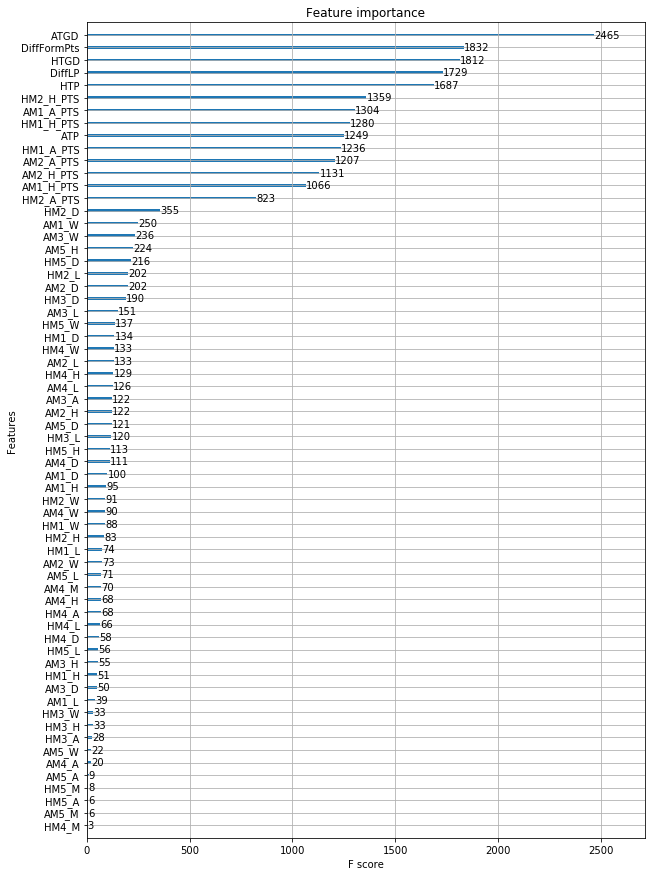

In [16]:
# Plot feature importance in the model.
from xgboost import plot_importance
from matplotlib import pyplot
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,15)

plot_importance(model)
pyplot.show()

In [17]:
# dump model
model.dump_model('dump.raw.txt')

AttributeError: 'XGBClassifier' object has no attribute 'dump_model'